# Preprocessing BRATS_METS dataset
Alright everyone, let's do this one last time.

Link to challenge: https://www.synapse.org/Synapse:syn53708249/wiki/626323

Infos about the dataset:
- the dataset contains "only" brain metastases of treatment-naive brain metastases mpMRI scans obtained from various institutions
- t1, t1c, t2, flair and segmentation is included
- no information about the patients or their primary cancers is available

The dataset structure looks like this:
```
BraTS2024-MET-Challenge-all
│
│__BraTS-MET-00001-000
    │
    │__BraTS-MET-00001-000-seg.nii.gz
    │__BraTS-MET-00001-000-t1c.nii.gz
    │__BraTS-MET-00001-000-t1n.nii.gz
    │__BraTS-MET-00001-000-t2f.nii.gz
    │__BraTS-MET-00001-000-t2n.nii.gz
│
│__...
```

Note that sometimes there's a second folder for a certain patient, like ```BraTS-MET-00591-000```and ```BraTS-MET-00591-001```. If I understand correctly, that just means that during the duration of the disease multiple mri scans were done for this certain patient.

In [1]:
# TO-DO:
# [ ] Percentile normalize images
# [ ] Create png images of each visible brain metastases slice in each scan
# [ ] Combine the four sequences and the segmentation mask into a single tfrecord file
# [ ] Profit?

In [28]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pathlib import Path
import random
import nibabel as nib
from skimage.measure import label

Paths

In [3]:
path_to_brats_mets_dataset_folder = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-Challenge-all")
path_to_brats_mets_png_slices = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-pngs")
path_to_brats_mets_tfrecords = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-tfrecords")

Custom Patient Class to store paths to different files

In [4]:
# create custom class for each patient to store all relevant information

class Patient:
    def __init__(self, id):
        self.id = id

        self.t1 = None # Path to T1 image
        self.t1c = None # Path to T1c image
        self.t2 = None # Path to T2 image
        self.flair = None # Path to FLAIR image

        self.tumor_segmentation = None # Path to tumor segmentation mask

In [5]:
brats_patients = []
patients_with_missing_data = []

patient_ids = [
    x for x in os.listdir(path_to_brats_mets_dataset_folder)
    if os.path.isdir(os.path.join(path_to_brats_mets_dataset_folder, x))
]

# loop through autmatic tumor segmentation ids
# get four regular sequences
# get tumor segmentation mask
for id in tqdm(patient_ids):
    patient = Patient(id = id)
    path_to_t1 = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t1n.nii.gz'
    path_to_t1c = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t1c.nii.gz'
    path_to_t2 = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t2w.nii.gz'
    path_to_flair = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t2f.nii.gz'
    path_to_automatic_segmentation = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-seg.nii.gz'

    if path_to_t1.is_file():
        patient.t1 = path_to_t1
    else:
        patients_with_missing_data.append(id)
        print(f'No T1 image for patient {id}')
    
    if path_to_t1c.is_file():
        patient.t1c = path_to_t1c
    else:
        patients_with_missing_data.append(id)
        print(f'No T1c image for patient {id}')

    if path_to_t2.is_file():
        patient.t2 = path_to_t2
    else:
        patients_with_missing_data.append(id)
        print(f'No T2 image for patient {id}')
    
    if path_to_flair.is_file():
        patient.flair = path_to_flair
    else:
        patients_with_missing_data.append(id)
        print(f'No FLAIR image for patient {id}')
    
    if path_to_automatic_segmentation.is_file():
        patient.tumor_segmentation = path_to_automatic_segmentation
    else:
        patients_with_missing_data.append(id)
        print(f'No tumor segmentation mask for patient {id}')

    brats_patients.append(patient)

100%|██████████| 652/652 [00:00<00:00, 15259.25it/s]


In [7]:
print(f'Number of patients with missing data: {len(patients_with_missing_data)}')
print(f'Number of patients with complete data: {len(brats_patients)}')

Number of patients with missing data: 0
Number of patients with complete data: 652


In [8]:
def visualize_random_patients(all_patients):

    # Funktion zum Laden und Anzeigen eines NIfTI-Bildes
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # 9 zufällige Patienten auswählen
    random_patients = random.sample(all_patients, 9)

    # 3x3 Grafik erstellen
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        
        # Zufällige MRT Sequenz auswählen
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        
        # MRT Bild laden
        image = load_nifti_image(sequence_path)
        
        # Segmentierung laden
        segmentation = load_nifti_image(patient.tumor_segmentation)
        
        # Größte sichtbare Tumorschicht finden
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # MRT Bild anzeigen
        ax.imshow(image[:, :, slice_index], cmap = 'gray')
        
        # Segmentierung farblich darüber legen
        ax.imshow(segmentation[:, :, slice_index], cmap='Reds', alpha=0.5)
        
        ax.axis('off')

        # Title
        max_value = np.max(image)
        mean_value = np.mean(image)
        min_value = np.min(image)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

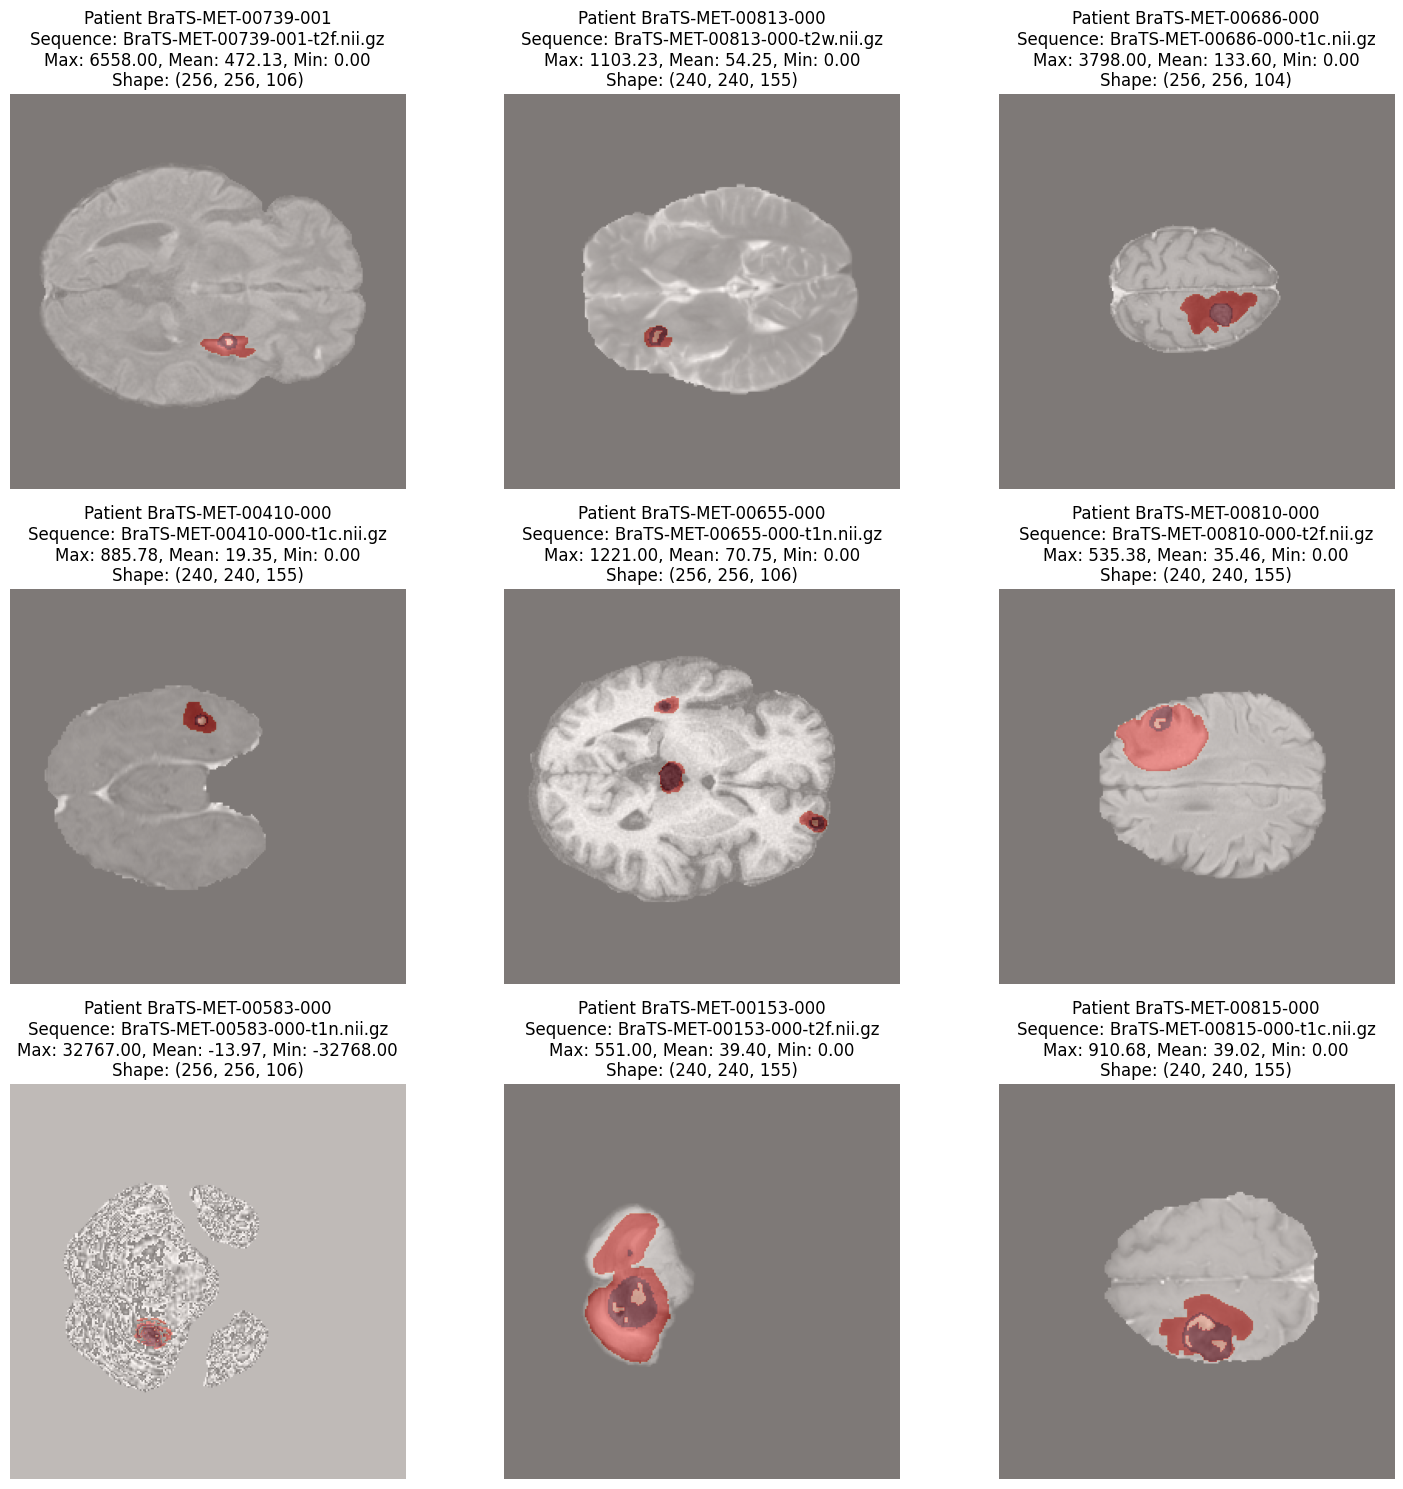

In [17]:
visualize_random_patients(brats_patients)

most images still need percentile normalization, reorientation and rotation

## Reorient, percentile normalize and rotate file

In [29]:
def rotate_and_normalize(image):
    # Rotate the image 90 degrees
    rotated_image = np.rot90(image, k=1)
    
    # Percentile normalization
    lower_percentile = np.percentile(rotated_image, 1)
    upper_percentile = np.percentile(rotated_image, 99)
    normalized_image = np.clip(rotated_image, lower_percentile, upper_percentile)
    normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
    
    return normalized_image

def load_nifti_image(path):

    img = nib.load(path)
    
    # rotate image to canonical orientation
    # If it's a Nifti1Pair, convert it to a Nifti1Image
    if isinstance(img, nib.Nifti1Pair):
        data = img.get_fdata()
        affine = img.affine  # nibabel usually infers or loads the affine
        # Create a brand-new Nifti1Header from the old header
        new_header = nib.Nifti1Header.from_header(img.header)
        # Make a Nifti1Image
        img = nib.Nifti1Image(data, affine, header=new_header)

    # Now safely reorient to canonical (RAS) orientation
    img_canonical = nib.as_closest_canonical(img)

    return img_canonical.get_fdata()

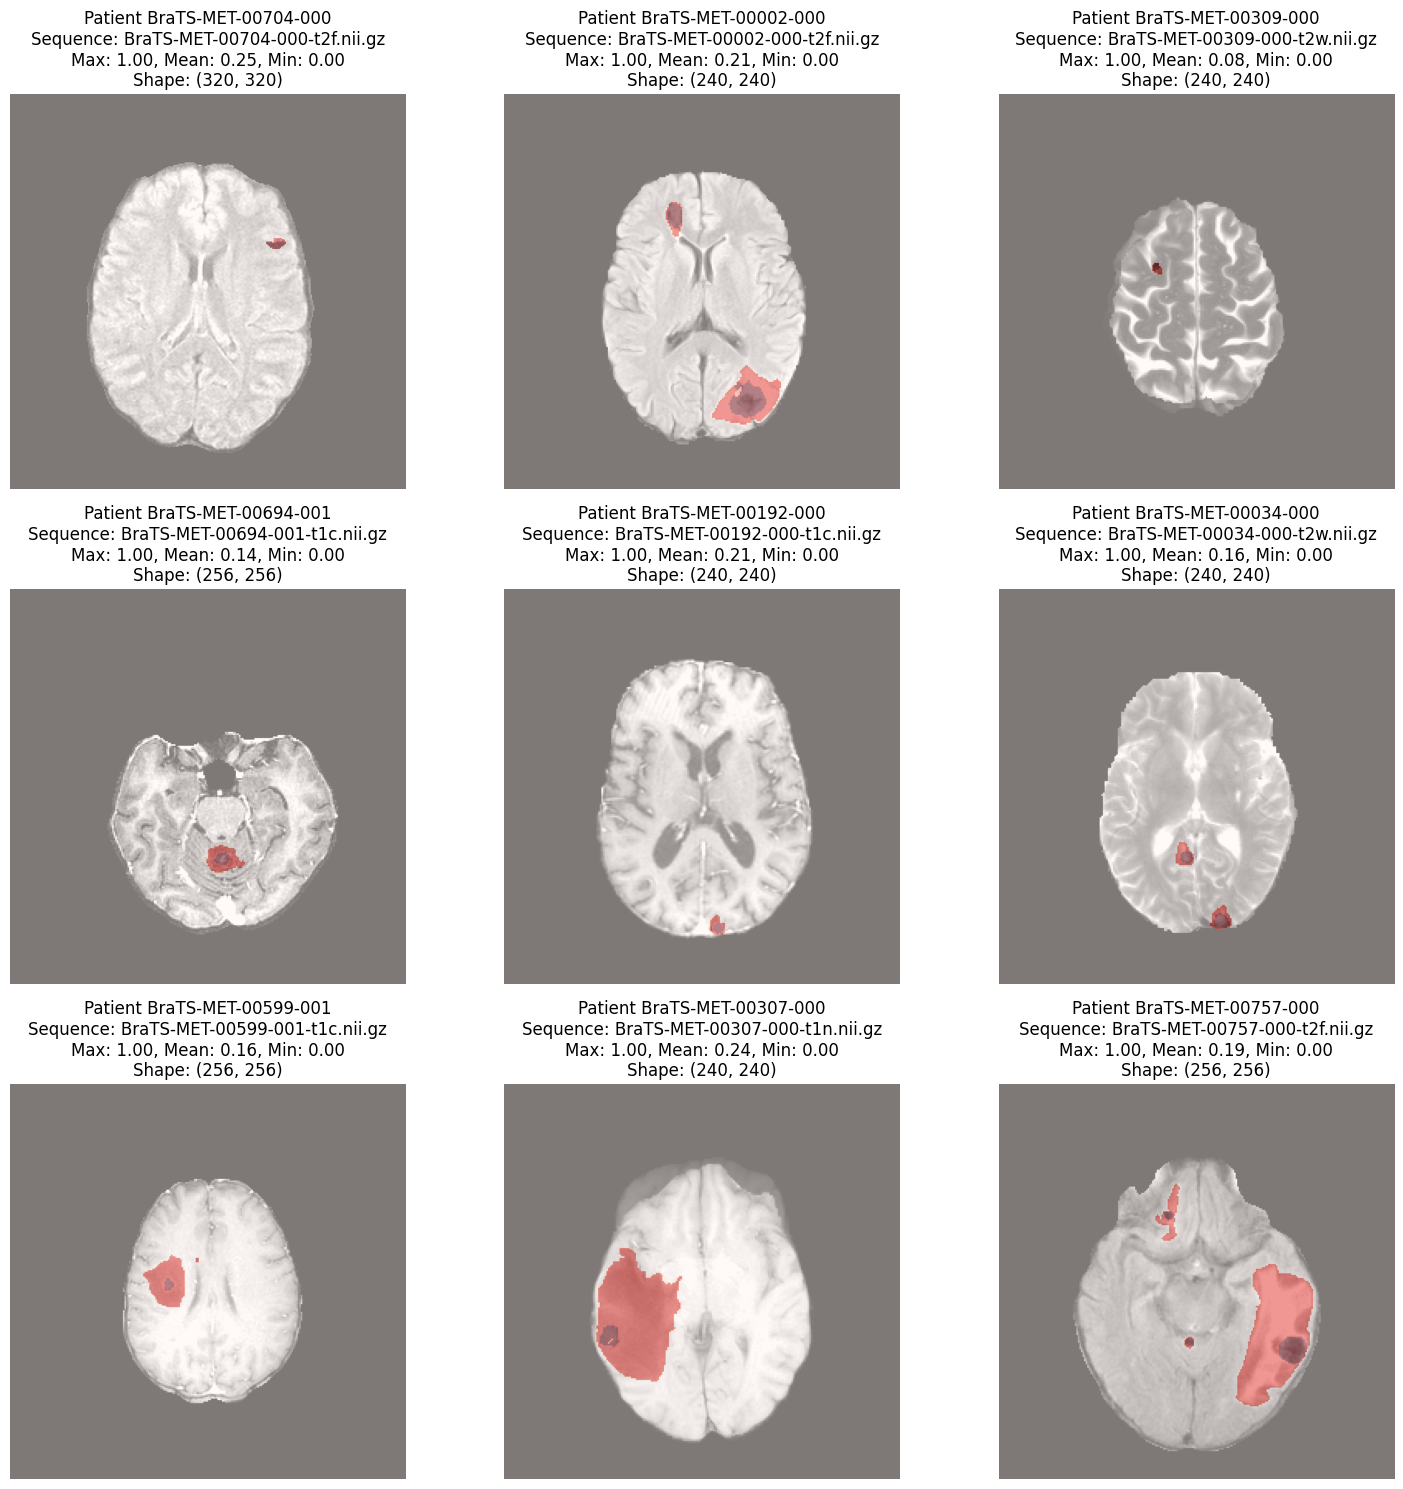

In [30]:
def visualize_random_patients_rotated_normalized(all_patients):

    random_patients = random.sample(all_patients, 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        image = load_nifti_image(sequence_path)
        # image = reorient_image(image).get_fdata()
        segmentation = load_nifti_image(patient.tumor_segmentation)
        # segmentation = reorient_image(segmentation).get_fdata()
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # Rotate and normalize the image and segmentation
        image_rotated_normalized = rotate_and_normalize(image[:, :, slice_index])
        segmentation_rotated = np.rot90(segmentation[:, :, slice_index], k=1)
        
        ax.imshow(image_rotated_normalized, cmap='gray', alpha = 1)
        ax.imshow(segmentation_rotated, cmap='Reds', alpha=0.5)
        ax.axis('off')

        max_value = np.max(image_rotated_normalized)
        mean_value = np.mean(image_rotated_normalized)
        min_value = np.min(image_rotated_normalized)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image_rotated_normalized.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

visualize_random_patients_rotated_normalized(brats_patients)

## Save the slice with the largest area for each metastasis

In [27]:
def show_segmentation_classes(patient):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    segmentation = load_nifti_image(patient.tumor_segmentation)
    unique_classes = np.unique(segmentation)
    
    print(f"Unique segmentation classes for patient {patient.id}: {unique_classes}")

# Example usage for a random patient
random_patient = random.choice(brats_patients)
show_segmentation_classes(random_patient)

Unique segmentation classes for patient BraTS-MET-00230-000: [0. 1. 2. 3.]


Meaning of each number:

Nonenhancing tumor core (NETC; Label 1): All portions of tumor core without contrast enhancement that are enclosed by enhancing tumor (ET). It represents the bulk of the tumor, which is what is typically considered for surgical excision.

Surrounding non-enhancing FLAIR hyperintensity (SNFH; Label 2): peritumoral edematous and infiltrated tissue, defined by the abnormal hyperintense signal envelope on the T2 FLAIR volumes, which includes the infiltrative non enhancing tumor, as well as vasogenic edema in the peritumoral region. Non tumor related FLAIR signal abnormality such as prior infarcts or microvascular ischemic white matter changes are NOT included.

Enhancing Tumor (ET; Label 3): All tumor portions with noticeable contrast enhancement on postcontrast T1-weighted images. Adjacent blood vessels, bleeding or intrinsic T1 hyperintensity are NOT included in this label.

I will focus on the Enhancing Tumor (ET; Label 3)

In [40]:
def rotate_and_normalize_3d(nifti_img):
    """
    Rotate the entire 3D volume 90 degrees counter clockwise around the (0,1) axes
    and apply a percentile normalization in 3D between 1st and 99th percentile.
    
    :param nifti_img: A nibabel Nifti1Image (or Nifti1Pair)
    :return: A new nibabel Nifti1Image whose voxel array has been rotated & normalized.
             The affine is the same as the input, so physical orientation might be mismatched.
    """
    # Extract the data as a 3D numpy array
    data_3d = nifti_img

    # Rotate the volume 90 deg counter clockwise in the axial plane
    # 'axes=(0, 1)' means we treat x-y plane; k=1 => 90 deg counter clockwise
    rotated_3d = np.rot90(data_3d, k=1, axes=(0,1))

    # Percentile normalization (based on the entire 3D volume)
    lower_p = np.percentile(rotated_3d, 1)
    upper_p = np.percentile(rotated_3d, 99)

    clipped_3d = np.clip(rotated_3d, lower_p, upper_p)
    normalized_3d = (clipped_3d - lower_p) / (upper_p - lower_p)

    return normalized_3d

In [41]:
def save_metastases_pngs_for_patient(patient, output_folder):

    sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
    images = [load_nifti_image(seq) for seq in sequences if seq is not None]
    # image = reorient_image(image).get_fdata()
    segmentation = load_nifti_image(patient.tumor_segmentation)

    # Rotate and normalize the image and segmentation
    images_rotated_normalized = [rotate_and_normalize_3d(image) for image in images]
    segmentation_rotated = np.rot90(segmentation, k=1, axes=(0,1))

    enhancing_tumor_mask = (segmentation_rotated == 3)

    labeled_mask = label(enhancing_tumor_mask, connectivity=1)  
    num_metastases = labeled_mask.max()

    print("Number of metastases found:", num_metastases)

In [43]:
print(random_patient.id)
save_metastases_pngs_for_patient(random_patient, path_to_brats_mets_png_slices)

BraTS-MET-00230-000
Number of metastases found: 12
